<a href="https://colab.research.google.com/github/nbalatamu/Hybrid-Dynamic-Models-for-Species-Dynamics/blob/main/HDModel_on_Simulation_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from tqdm.notebook import tqdm
import time
from sklearn.metrics import r2_score

%matplotlib inline

In [ ]:
!pip install torchdiffeq

In [ ]:
from torchdiffeq import odeint_adjoint
import time

In [ ]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

set_random_seeds()

#Import Data

In [ ]:
# Load the dictionary from the pickle file
with open('results_simulation.pkl', 'rb') as f:
    sim_results = pickle.load(f)

In [ ]:
key = list(sim_results.keys())
sim_data = 1

In [ ]:
result = sim_results[sim_data]

e = result['e'].transpose(0, 1)
x = result['pred_y'].squeeze(1)
t = result['t']

#Train-Val-Test Split

In [ ]:
def data_split(x, e, test_size, val_size):

  #This function splits the data into train, validation, and test sets

  train_size = x.shape[0] - val_size - test_size

  train_x, train_e = x[:train_size], e[:train_size]
  val_x, val_e = x[train_size:train_size+val_size], e[train_size:train_size+val_size]
  test_x, test_e = x[train_size+val_size:], e[train_size+val_size:]

  return train_x, val_x, test_x, train_e, val_e, test_e

In [ ]:
#Data_split

val_time_points = 10
test_time_points = 10

train_time_points = x.shape[0] - val_time_points - test_time_points

train_x, val_x, test_x, train_e, val_e, test_e = data_split(x, e, test_time_points, val_time_points)

#Get Batches

In [ ]:
t_train = t[ : train_time_points]
t_val = t[ : train_time_points + val_time_points]
t_test = t[ : train_time_points + val_time_points + test_time_points]

In [ ]:
def get_batch(train_x, train_e, batch_time = 12, batch_size = 8):
  s = torch.from_numpy(np.random.choice(np.arange(train_time_points - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = train_x[s]  # (batch_size, 1, emb)
  batch_t = t_train[:batch_time]  # (T)
  batch_y = torch.stack([train_x[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  batch_e = torch.stack([train_e[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  return batch_y0, batch_t, batch_y, batch_e

#Model B - HD Model

In [ ]:
# Define the combined ODE model
class CombinedODEModel(nn.Module):
    def __init__(self, n, m, t_step):
        super(CombinedODEModel, self).__init__()
        self.n = n
        self.m = m
        self.t_step = t_step

        self.net_1 = nn.Linear(n, m)
        self.net_2 = nn.Linear(m, m, bias=False)
        self.net_3 = nn.Sequential(
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU()
        )

        self.e = None  # Placeholder for control variables

    def set_control_variables(self, e):
        self.e = e

    def forward(self, t, x):
        # Get the control variables at the current time step for all batches
        t_index = int(t.item() / self.t_step)
        e_t = self.e[t_index, :, :]
        return x * (self.net_1(e_t) + self.net_2(x) + self.net_3(x))

#Run Model

In [ ]:
def train_and_optimize_model(model_class,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_val, train_time_points, val_time_points, val_x,
                             niters=100, early_stopping_patience=20, early_stopping_min_delta=1e-4, model_args=None):

    best_val_loss = float('inf')
    best_hyperparams = None
    best_model_state = None

    for batch_time, batch_size, lr in hyperparameters:
        print(f"Training with batch_time={batch_time}, batch_size={batch_size}, lr={lr}")

        # Create the model
        if model_args:
          model = model_class(*model_args) # Unpack arguments if provided
        else:
          model = model_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loss = []
        val_loss = []

        best_epoch_val_loss = float('inf')
        patience_counter = 0

        for iter in tqdm(range(niters + 1)):
            # Train loss
            optimizer.zero_grad()
            batch_y0, batch_t, batch_y, batch_e = get_batch(train_x, train_e, batch_time, batch_size)
            model.set_control_variables(batch_e)
            y_pred = odeint_adjoint(model, batch_y0, batch_t, rtol=1e-3, atol=1e-4, method='euler')
            loss = torch.mean(torch.square(y_pred - batch_y))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            # Val loss
            with torch.no_grad():
                model.set_control_variables(e.unsqueeze(1))
                y_pred_val = odeint_adjoint(model, x.unsqueeze(1)[0, :, :], t_val, rtol=1e-3, atol=1e-4, method='euler')
                val_loss_value = torch.mean(torch.square(y_pred_val[train_time_points:,:,:] - val_x.unsqueeze(1)))
                val_loss.append(val_loss_value.item())

            if torch.isnan(val_loss_value):
                print(f"NaN detected for batch_time={batch_time}, batch_size={batch_size}, lr={lr} at epoch {iter}")
                break

            if val_loss_value < best_epoch_val_loss - early_stopping_min_delta:
                best_epoch_val_loss = val_loss_value
                patience_counter = 0
                if val_loss_value < best_val_loss:
                    best_val_loss = val_loss_value
                    best_hyperparams = {'batch_time': batch_time, 'batch_size': batch_size, 'learning_rate': lr}
                    best_model_state = model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {iter}")
                break

        print(f"Best Val Loss after training: {best_epoch_val_loss}")

        plt.figure(figsize=(4, 2))
        plt.plot(train_loss, label='train')
        plt.plot(val_loss, label='val')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    print(f"Best hyperparameters: {best_hyperparams}, Best validation loss: {best_val_loss}")

    return best_model_state, best_hyperparams, best_val_loss

Working on Simulation Data:  1
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.039436087012290955


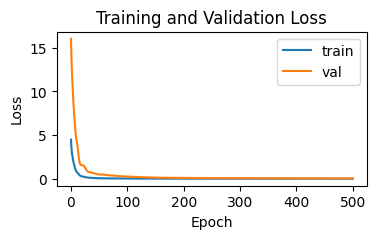

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.039436087012290955
Test loss for 1: 0.13728231191635132
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.027884977 24.460625
Predicted values range: 0.04555518 24.373732
R² for 1: -135.72313275864678
Slope for 1: 1.0060830683615722


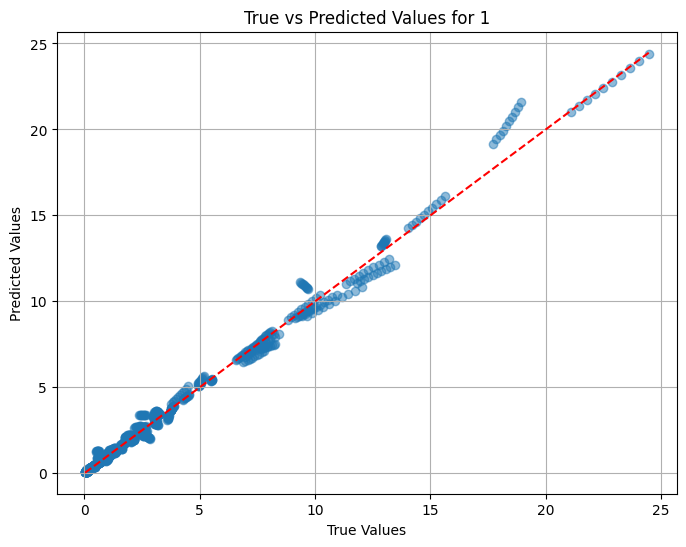

Working on Simulation Data:  2
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.0682753175497055


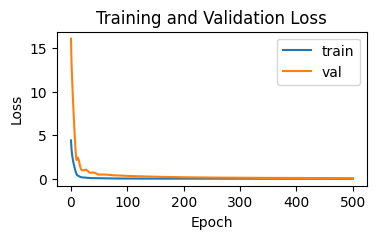

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.0682753175497055
Test loss for 2: 0.25135719776153564
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.054919116 25.159851
Predicted values range: 0.04658077 23.28702
R² for 2: -264.44841782771107
Slope for 2: 0.9962064963139031


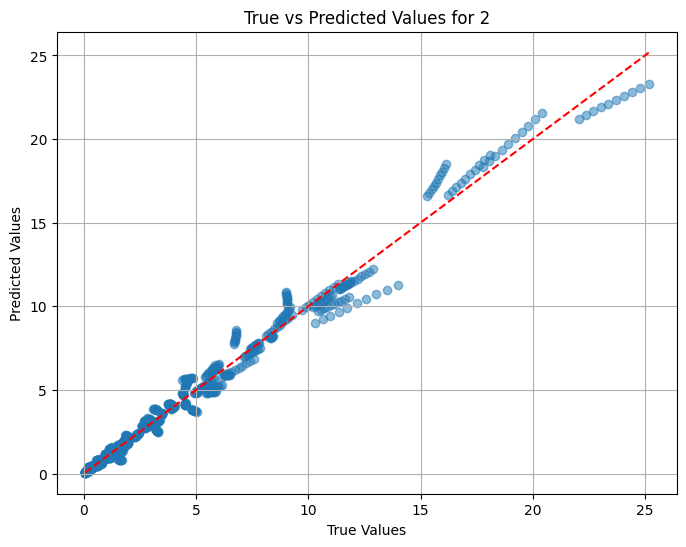

Working on Simulation Data:  3
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.0235271118581295


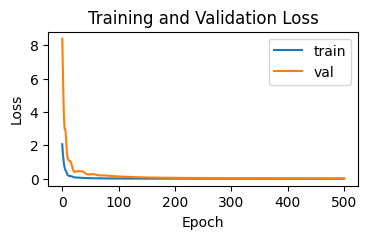

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.0235271118581295
Test loss for 3: 0.1012183353304863
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.019691698 22.136484
Predicted values range: 0.0165926 21.481907
R² for 3: -214.4015481365201
Slope for 3: 0.9692205872382746


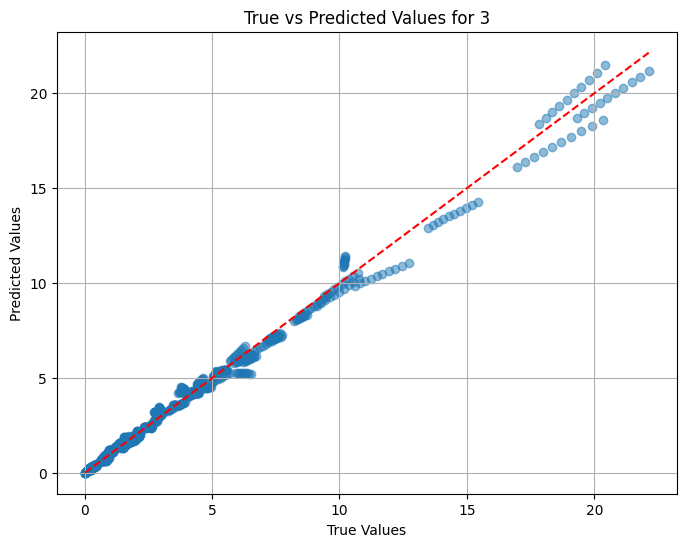

Working on Simulation Data:  4
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.018761057406663895


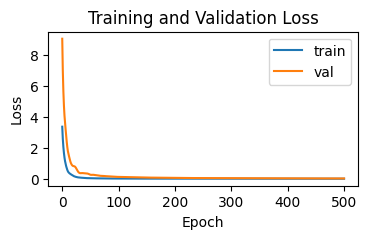

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.018761057406663895
Test loss for 4: 0.04800272360444069
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.020899124 13.759434
Predicted values range: 0.019808637 12.837054
R² for 4: -293.11324124788536
Slope for 4: 0.9722753315384282


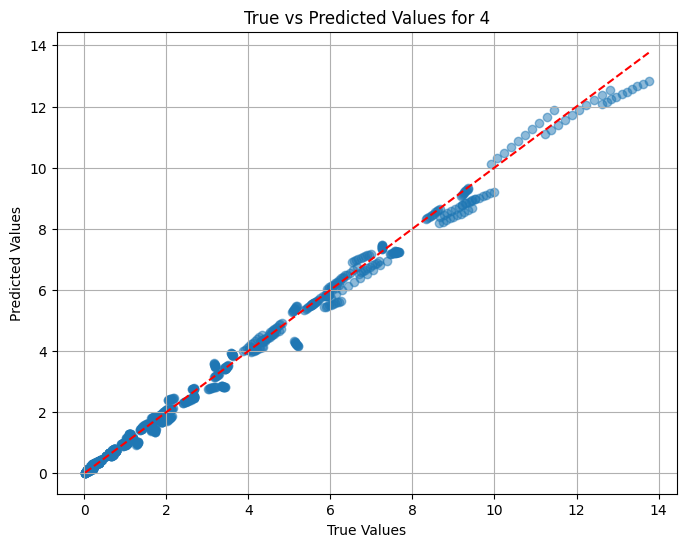

Working on Simulation Data:  5
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.008845971897244453


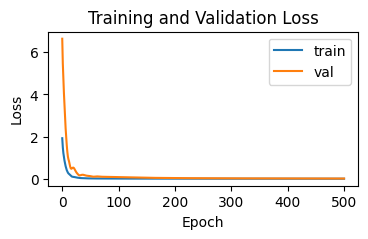

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.008845971897244453
Test loss for 5: 0.020720545202493668
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.01190613 14.683764
Predicted values range: 0.01400848 14.508384
R² for 5: -304.15589601933306
Slope for 5: 0.9894819104323211


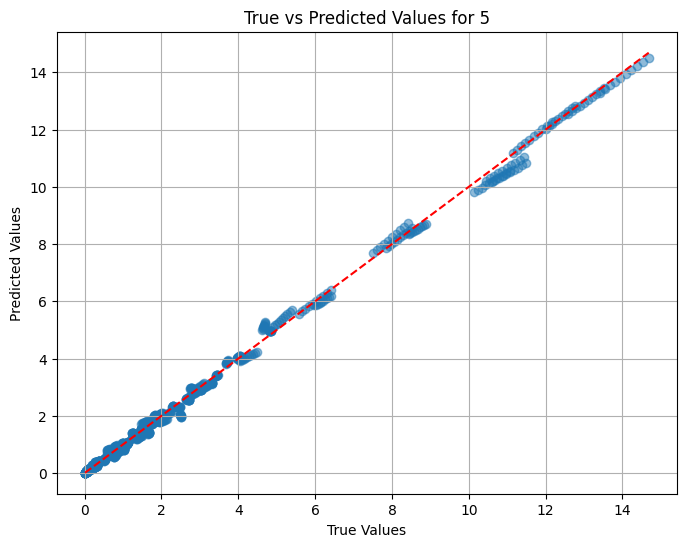

Working on Simulation Data:  6
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.03715739771723747


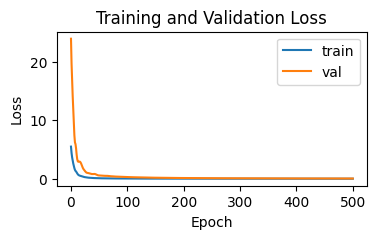

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.03715739771723747
Test loss for 6: 0.17781102657318115
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.013897251 24.60834
Predicted values range: 0.014052698 23.347227
R² for 6: -1312.0967260960722
Slope for 6: 0.9766266917535332


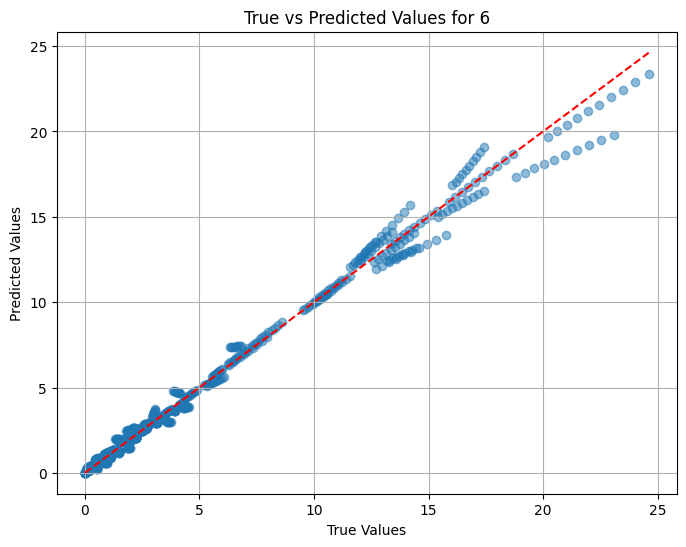

Working on Simulation Data:  7
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.042490486055612564


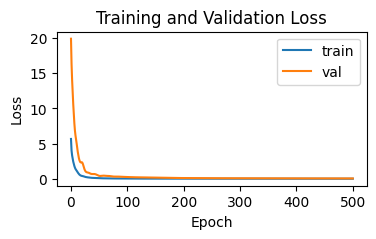

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.042490486055612564
Test loss for 7: 0.1615680307149887
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.017728167 26.759712
Predicted values range: 0.035746742 25.484068
R² for 7: -1046.679274854566
Slope for 7: 1.0012414591281358


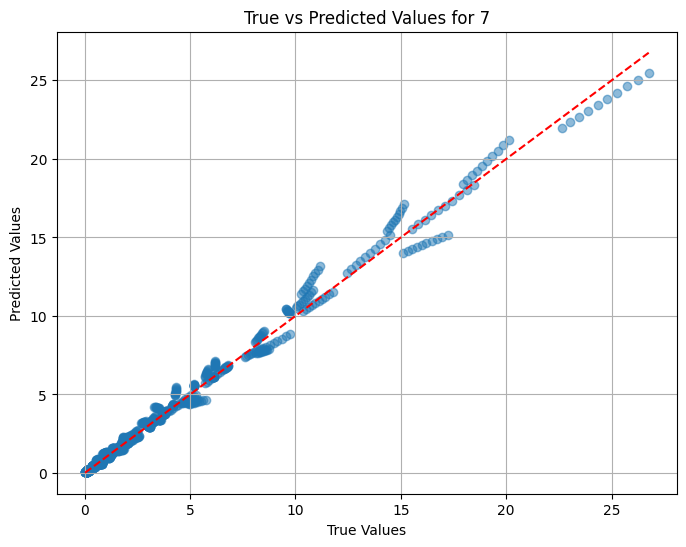

Working on Simulation Data:  8
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.01755537837743759


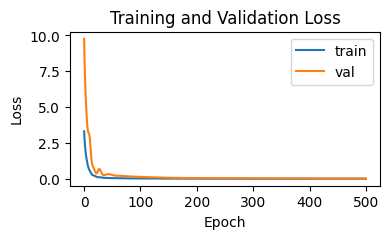

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.01755537837743759
Test loss for 8: 0.04913533478975296
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.013662884 15.795745
Predicted values range: 0.01289393 15.647055
R² for 8: -2824.046554006516
Slope for 8: 1.0156249555369272


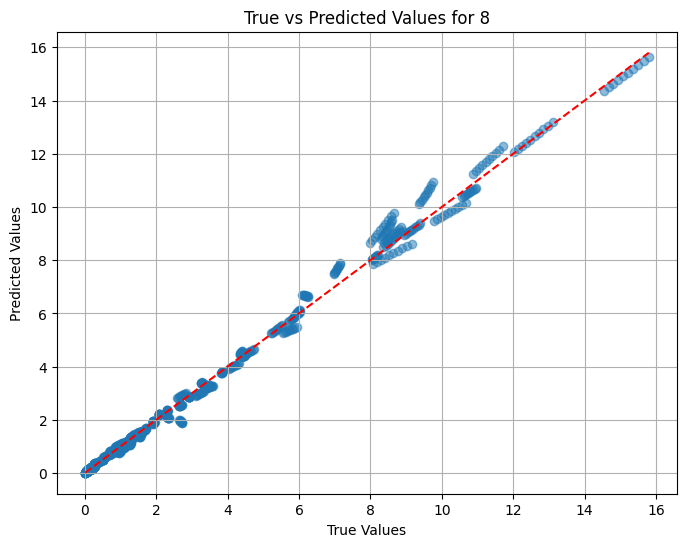

Working on Simulation Data:  9
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.0424075685441494


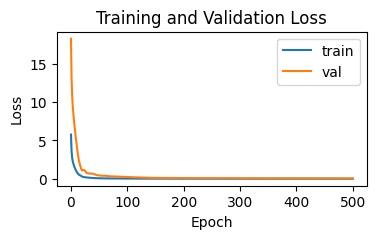

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.0424075685441494
Test loss for 9: 0.14352750778198242
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.00868911 25.286657
Predicted values range: 0.013868899 26.400763
R² for 9: -152.6902600367594
Slope for 9: 1.0001332682824593


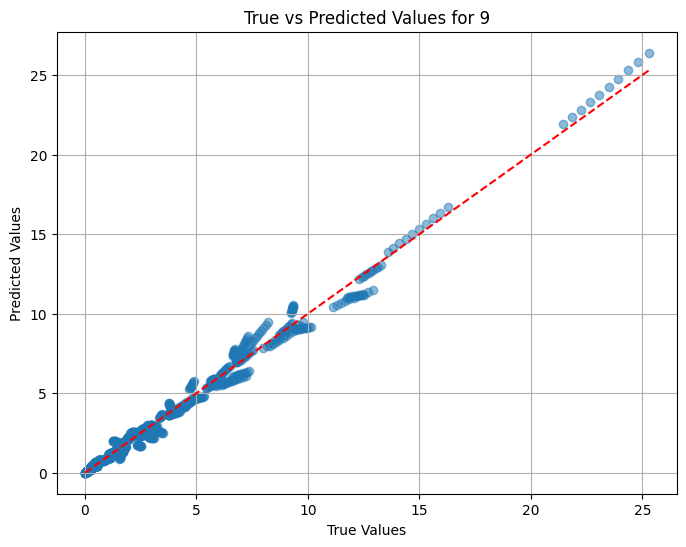

Working on Simulation Data:  10
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

Best Val Loss after training: 0.009973897598683834


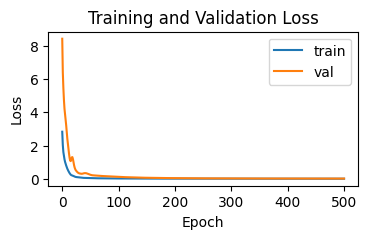

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.009973897598683834
Test loss for 10: 0.022425178438425064
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.01935141 14.54012
Predicted values range: 0.02201426 14.602113
R² for 10: -522.4163274481141
Slope for 10: 1.0106708559362052


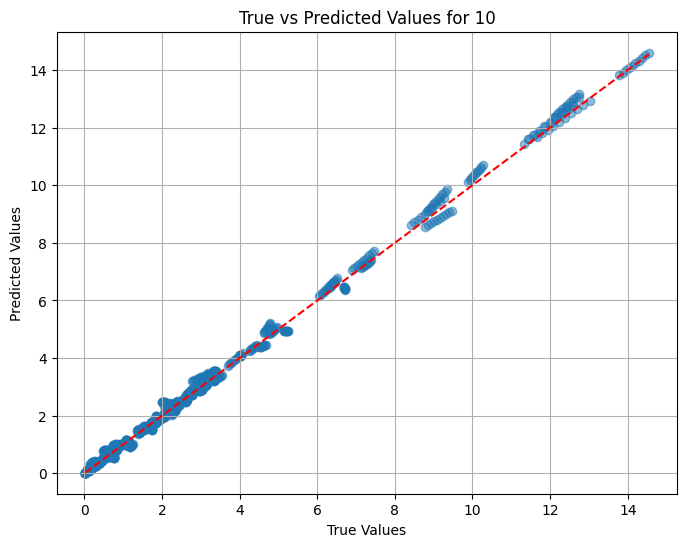

Working on Simulation Data:  11
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/501 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
r_2_all = []
slope_all = []

for sim_data in key:

  result = sim_results[sim_data]

  e = result['e'].transpose(0, 1)
  x = result['pred_y'].squeeze(1)
  t = result['t']

  n = e.shape[1]
  m = x.shape[1]

  train_x, val_x, test_x, train_e, val_e, test_e = data_split(x, e, test_time_points, val_time_points)

  print("Working on Simulation Data: ", sim_data)

  # Define hyperparameters
  hyperparameters = [
      (179, 1, 0.001),]  # (batch_time, batch_size, learning_rate)

  best_model_state, best_hyperparams, best_val_loss = train_and_optimize_model(CombinedODEModel,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_val, train_time_points, val_time_points, val_x,
                             niters=500, early_stopping_patience=20, early_stopping_min_delta=1e-4, model_args=(n,m,0.0020))

  # Load the best model state
  best_model = CombinedODEModel(n, m, 0.0020)
  best_model.load_state_dict(best_model_state)
  best_model.eval()

  # Predict the test data
  with torch.no_grad():
    best_model.set_control_variables(e.unsqueeze(1))
    y_pred_test = odeint_adjoint(best_model, x.unsqueeze(1)[0, :, :], t_test, rtol=1e-3, atol=1e-4, method='euler')
    test_loss = torch.mean(torch.square(y_pred_test[train_time_points + val_time_points:, :, :] - test_x.unsqueeze(1)))

  print(f"Test loss for {sim_data}: {test_loss.item()}")

  # Calculate R² and slope
  true_values = test_x.unsqueeze(1).squeeze().numpy()
  predicted_values = y_pred_test[train_time_points + val_time_points:, :, :].squeeze().numpy()

  # Print shapes of true and predicted values
  print("Shape of true values:", true_values.shape)
  print("Shape of predicted values:", predicted_values.shape)

  # Check min and max of true and predicted values
  print("True values range:", true_values.min(), true_values.max())
  print("Predicted values range:", predicted_values.min(), predicted_values.max())

  r2 = r2_score(true_values, predicted_values)
  slope, intercept = np.polyfit(true_values.flatten(), predicted_values.flatten(), 1)

  r_2_all.append(r2)
  slope_all.append(slope)

  print(f"R² for {sim_data}: {r2}")
  print(f"Slope for {sim_data}: {slope}")

   # Plot true vs predicted
  plt.figure(figsize=(8, 6))
  plt.scatter(true_values.flatten(), predicted_values.flatten(), alpha=0.5)
  plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title(f'True vs Predicted Values for {sim_data}')
  plt.grid(True)
  plt.show()

In [ ]:
r2_score(true_values, predicted_values)

-522.4163274481141

In [ ]:
HDM_on_sim_results_dict = {
        'r2': r_2_all,
        'slope': slope_all
    }

In [ ]:
with open('HDM_on_sim_results_dict.pkl', 'wb') as f:
    pickle.dump(HDM_on_sim_results_dict, f)